# tolkien2vec


Turns lord of the rings into vectors

Word2Vec trains a simple neural network with a single hidden layer to learn patterns and words,
And then we use the weights of the hidden layer as vectors that tell us about the relations between words.[2]

I use the Skip-gram method of Word2Vec in this example which is explained in this post[2]. the short version is that we train the network to figure out the probablity that words are near each other. Because words that are related are next to each other in sentences this creates meaningfull  

I started with Thrones2Vec from this tutorial [1], but the code didn't work in the end so I modified it until it did work and copied code snippets from a lot of other tutorials to cobble this together. Once I began to understand the concept of Word2Vec better I realized that the code in the first [1] tutorial wasn't actually that good because it skipped some crucial steps like removing stop words. 



## Imports

In [1]:
import sys
import glob
from nltk.corpus import stopwords 
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize 
import codecs
import multiprocessing
%matplotlib notebook # makes plots interactivisch (doesn't work amazingly)

## Get the books from the data folder

I removed the forewords and apendices because they where totally different from the main text
Todo: add The Hobbit, Children of Hurin, The Simarillion

In [3]:
book_filenames = sorted(glob.glob("./data/*.txt"))
book_filenames

['./data/Fellowship of the Ring, The - J. R. R. Tolkien.txt',
 './data/Return of the King, The - J. R. R. Tolkien.txt',
 './data/Two Towers, The - J. R. R. Tolkien.txt']

Combine the books into one huge string.

In [4]:
corpus_raw = u"" # sidenote the 'u' means that it's a empty unicode string
for book_filename in book_filenames:
    print("Reading `{0}`...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading `./data/Fellowship of the Ring, The - J. R. R. Tolkien.txt`...
Corpus is now 989784 characters long

Reading `./data/Return of the King, The - J. R. R. Tolkien.txt`...
Corpus is now 1971627 characters long

Reading `./data/Two Towers, The - J. R. R. Tolkien.txt`...
Corpus is now 2804675 characters long



## Split the complete text into sentences

`sent_tokenize` is a tool from the Natural Language Toolkit `ntlk` that splits text into sentences

In [41]:
corpus_sentences = sent_tokenize(corpus_raw)
print(corpus_sentences[3700])

A heavy weight was settling steadily on Frodo's heart, and he regretted now with every step forward that he had ever thought of challenging the menace of the trees.


## Split each sentence into an array of tokens

Tokens are words & punctuation

In [42]:
corpus_tokenized = []
for corpus_sentence in corpus_sentences:
    if len(corpus_sentence) > 0:
        corpus_tokenized.append(word_tokenize(corpus_sentence))
print(corpus_tokenized[3700])

['A', 'heavy', 'weight', 'was', 'settling', 'steadily', 'on', 'Frodo', "'s", 'heart', ',', 'and', 'he', 'regretted', 'now', 'with', 'every', 'step', 'forward', 'that', 'he', 'had', 'ever', 'thought', 'of', 'challenging', 'the', 'menace', 'of', 'the', 'trees', '.']


## remove stopwords, numbers and punctuation

In [2]:
STOP_WORDS = set(stopwords.words('english'))

In [43]:
# filter these sentences
def filter_stopwords(word_tokens, stop_words):
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            if w.isalpha():
                filtered_sentence.append(w.lower())
            
    return filtered_sentence 
  

filtered_sentences = []
for unfiltered_sentence in corpus_tokenized:
    if len(unfiltered_sentence) > 0:
        filtered_sentences.append(filter_stopwords(unfiltered_sentence, STOP_WORDS))

print(filtered_sentences[3700])

['a', 'heavy', 'weight', 'settling', 'steadily', 'frodo', 'heart', 'regretted', 'every', 'step', 'forward', 'ever', 'thought', 'challenging', 'menace', 'trees']


## Train Word2Vec on the text of Lord of the Rings

Best settings discovered yet:

*1st working example*
* `filtered_sentences` sentences of the 3 lotr books, stopwords filtered away, all lowercased, punctuation removed
* `sg=1` skip-gram instead of Bag-of-words (better for less frequent words)
* `size=1000` randomly chosen, big = good?
* `window=7` how many words looked at surounding each word to determine context
* `min_count=5` how many times a word needs to exist in the text to be counted
* `sample=1e-3` downsampling that reduces importance of frequently used words
* `workers=multiprocessing.cpu_count()` uses amount of cores availble
* `seed=1` reproducable by seeding RNG


In [8]:
from gensim.models import Word2Vec

# size: the dimensionality of the embedding vectors.
# window: the maximum distance between the current and predicted word within a sentence.
model = Word2Vec(
    filtered_sentences,
    sg=1,
    size=1000, 
    window=7, 
    min_count=5, 
    sample = 1e-3,
    workers=multiprocessing.cpu_count(),
    seed=1
)
model.wv.save_word2vec_format("tolkien.txt", binary=False)


## Transform 1000 dimensional data into 2 dimensions

this is dark magic that I don't understand

In [10]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [11]:
all_word_vectors_matrix = model.wv.vectors

In [12]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

## Create graph with the vectors in 2d space

In [13]:
import pandas
# plot the big picture
points = pandas.DataFrame([
    (word, coords[0], coords[1])
    for word, coords in [
        (word, all_word_vectors_matrix_2d[model.wv.vocab[word].index])
        for word in model.wv.vocab
    ]
], columns=["word", "x", "y"])

**Quick check to see if data looks alright**

In [15]:
print(points[points['word'].str.match('frodo')])

      word         x          y
280  frodo -3.108158 -27.031281


In [14]:
print(points)

            word          x          y
0            the -37.098202  -6.737819
1     fellowship -38.957027  -3.356970
2             of -55.595997  -5.091047
3           ring -40.126755  15.750142
4          being   1.813797  19.682974
5          first -12.006318  -5.125643
6           part -52.727470   1.035302
7           lord -45.117416 -13.221221
8          rings -50.709347  -5.100649
9             by   6.178978  -8.624210
10         three -33.290215  -8.783772
11           sky  -0.052582 -81.475655
12         seven -48.040989  -6.819640
13         halls -26.133009 -17.857668
14         stone  29.236263 -72.605621
15          nine -45.475357  -5.309891
16        mortal -49.079948  -3.788630
17           men -49.536724  -2.384825
18        doomed -40.195862   4.880493
19           die -48.270607  17.783220
20           one -40.037209  15.774866
21          dark  -1.219993 -72.500626
22        throne -25.036057 -19.219261
23            in -37.406357  -6.423452
24          land -29.6204

<IPython.core.display.Javascript object>


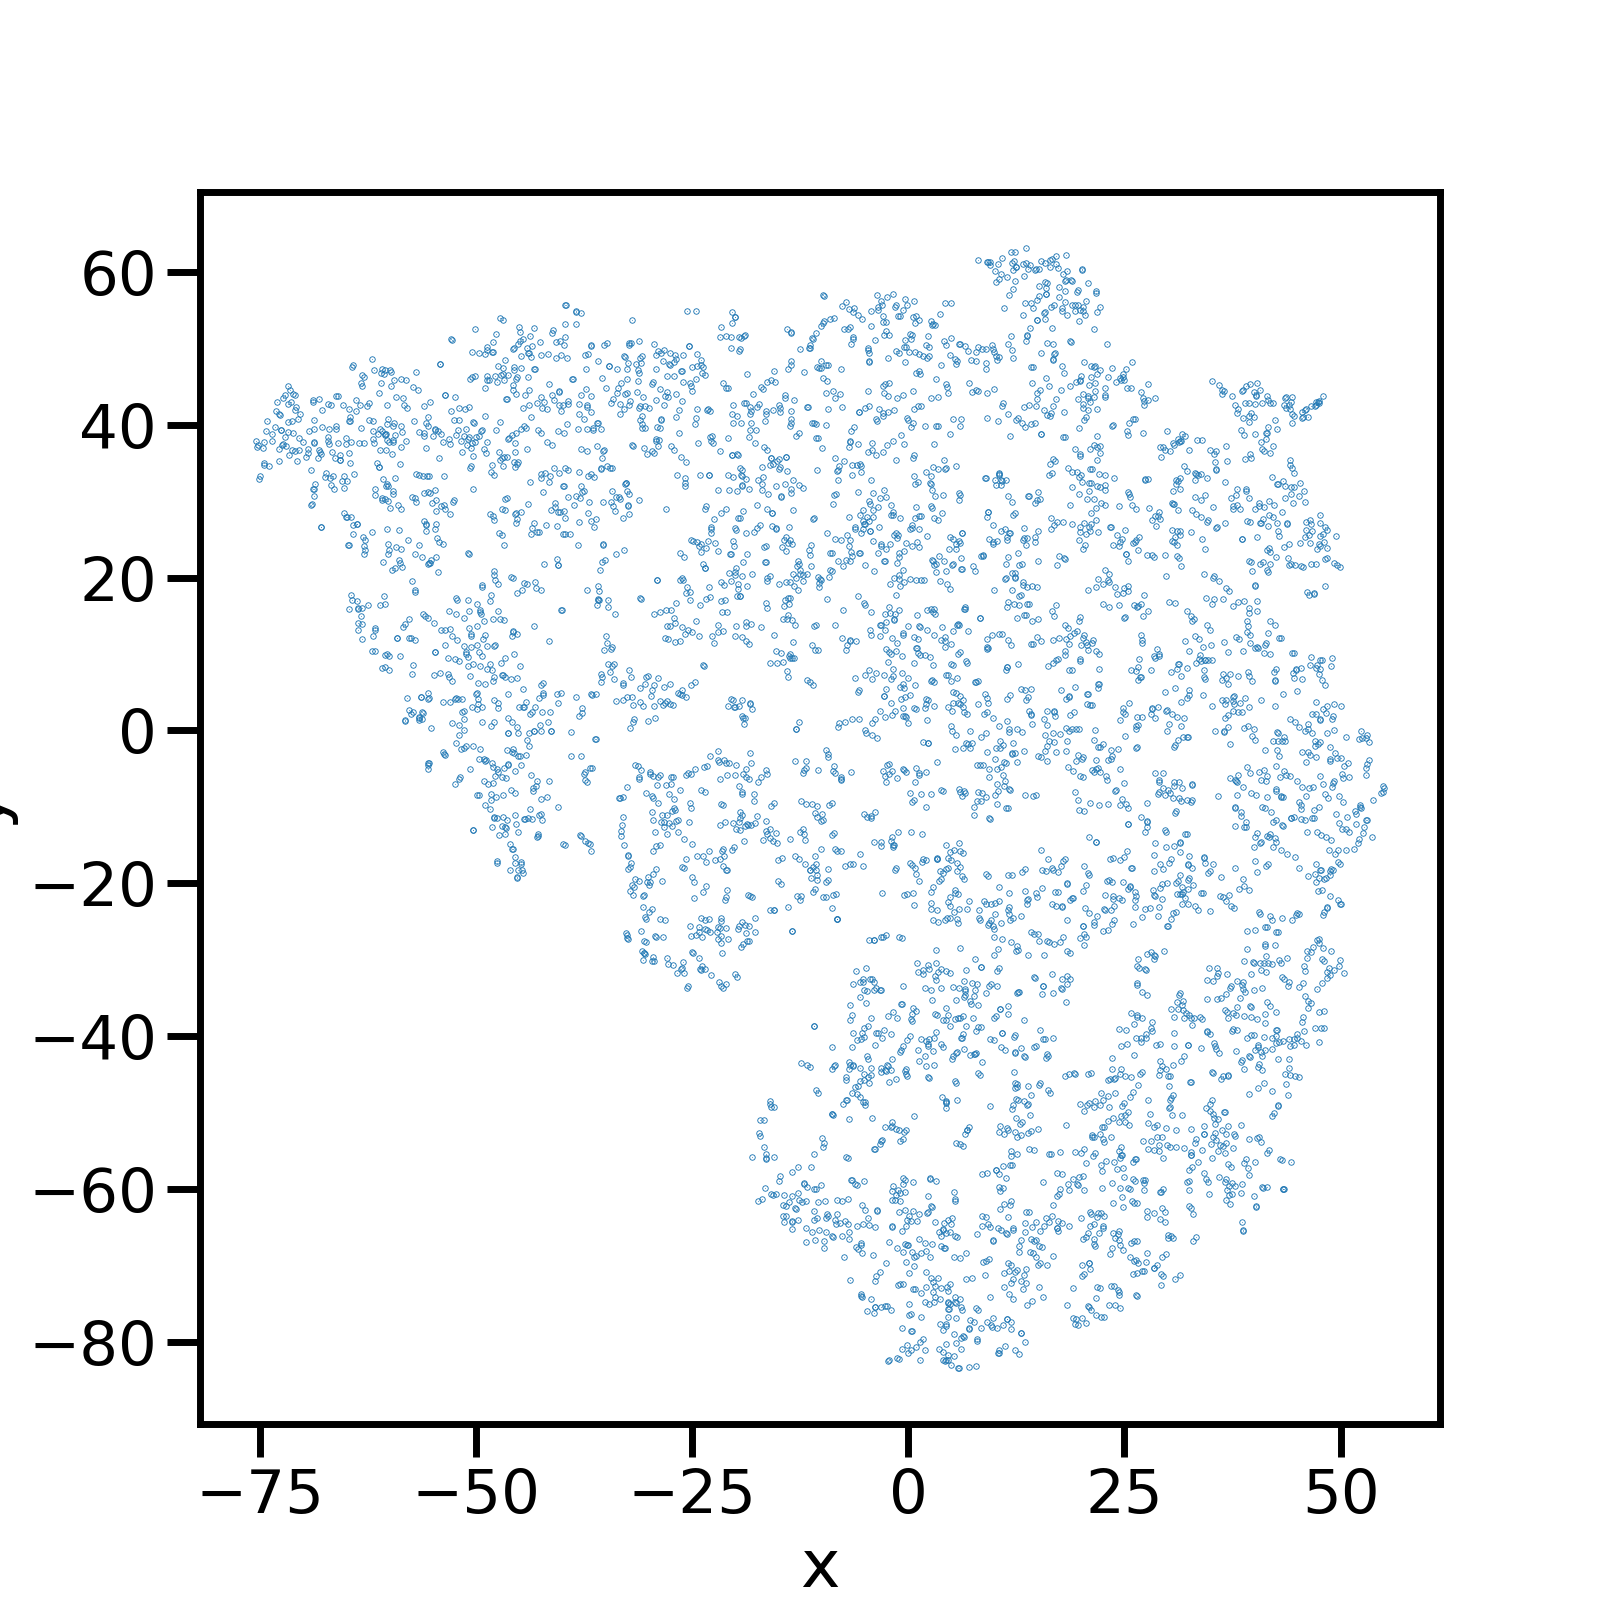

In [16]:
import seaborn
seaborn.set_context("poster")
points.plot.scatter("x", "y", s=0.1, figsize=(8,8))

## Graph with labels of a certain region

In [17]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x)&
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y)&
        (points.y <= y_bounds[1])
    ]

    ax = slice.plot.scatter("x", "y", s=1, figsize=(8,8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005,point.y, point.word, fontsize=8)

<IPython.core.display.Javascript object>


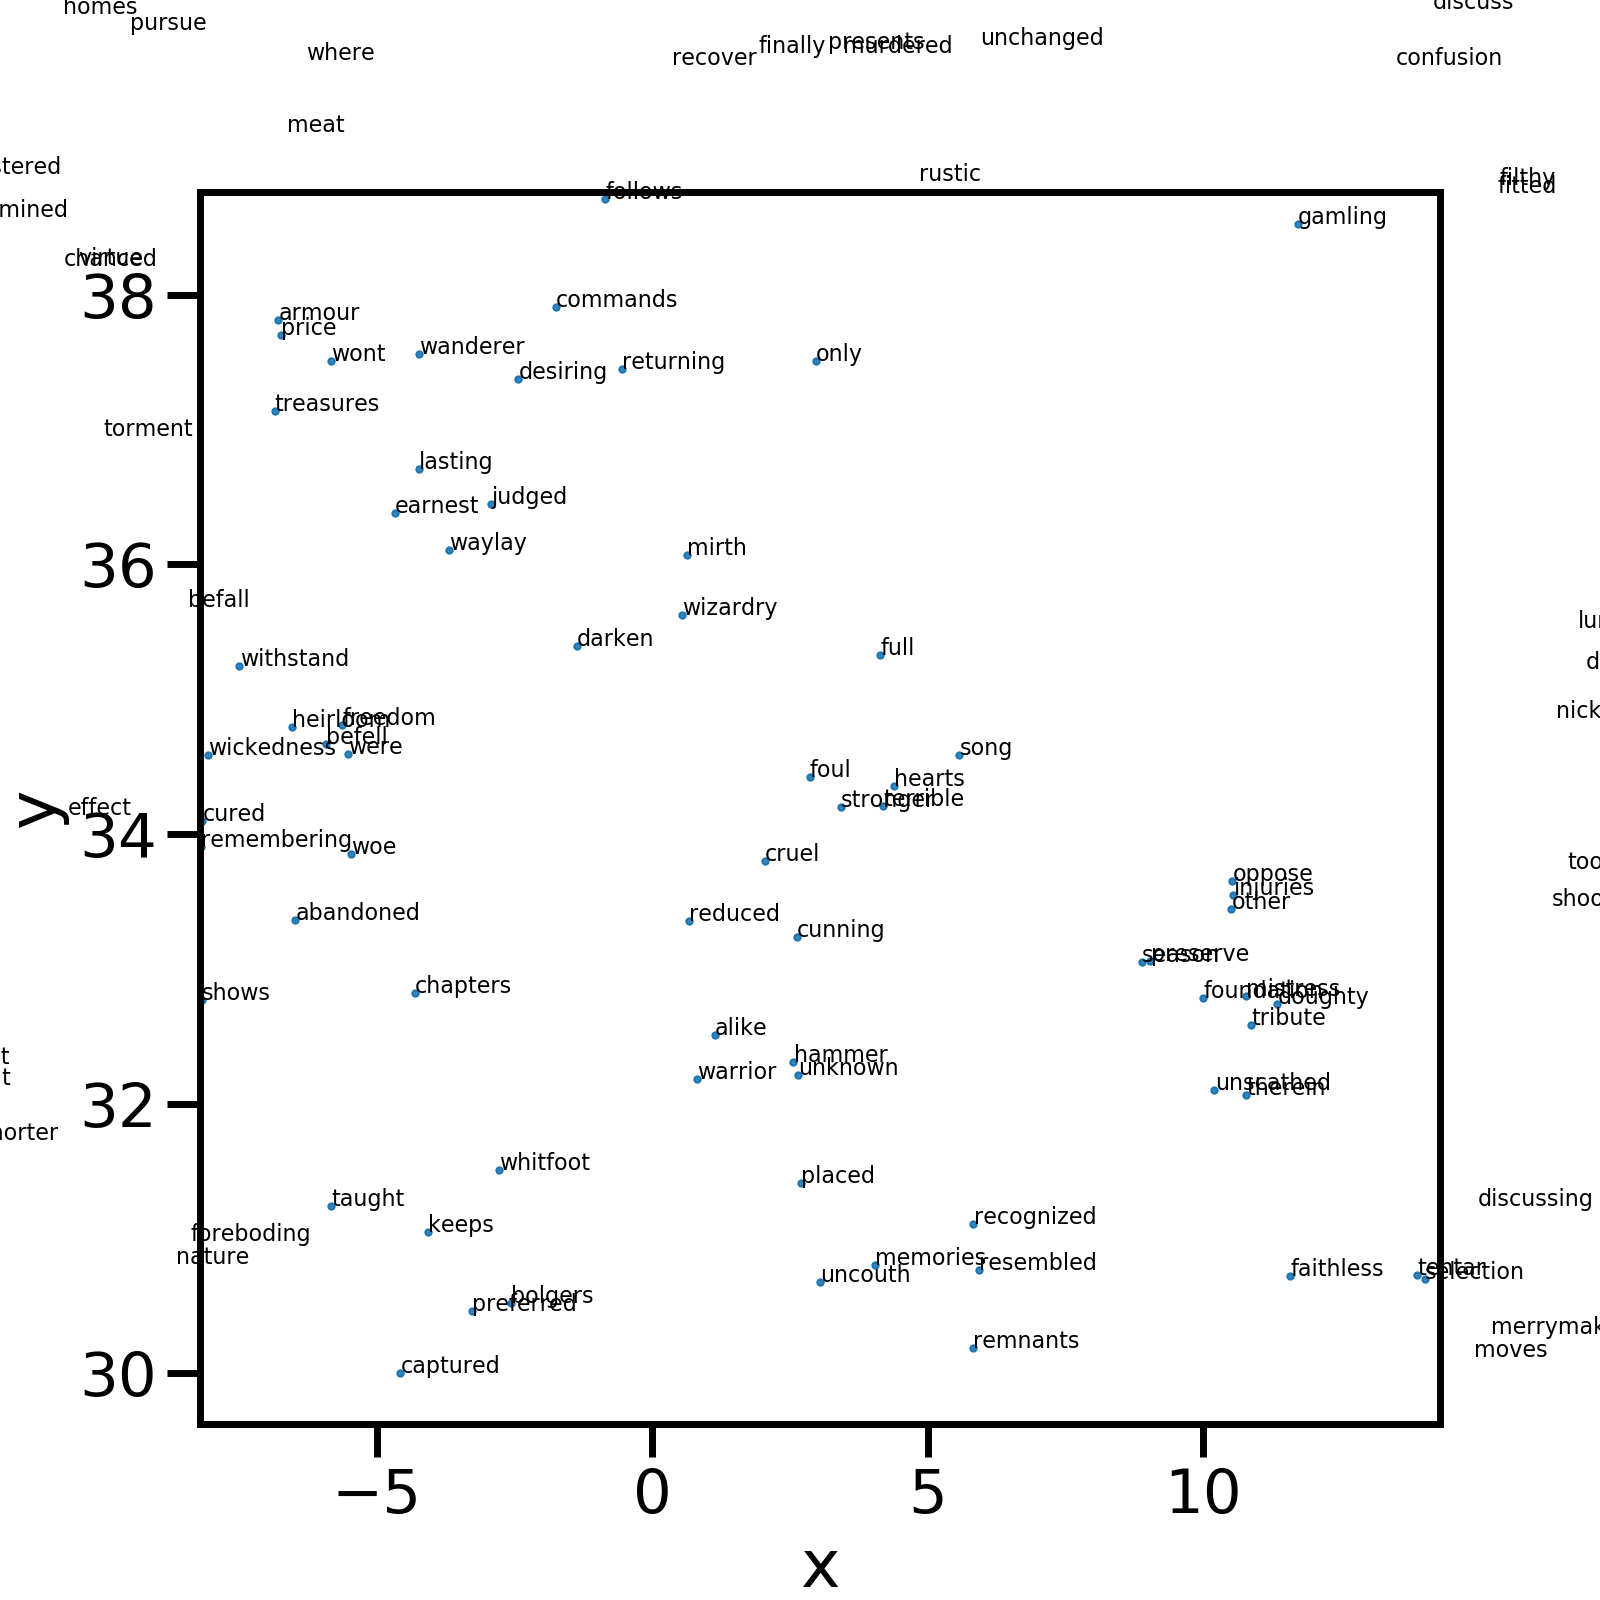

In [18]:
# if this errors you probably reversed the values in a tuple
# 59.421249  7.957841
plot_region(x_bounds=(-20, 20), y_bounds=(30, 60))

## Look up things that are related

In [19]:
model.wv.most_similar('frodo', topn=10)

[('sam', 0.9578309059143066),
 ('merry', 0.9328782558441162),
 ('gollum', 0.9320517182350159),
 ('pippin', 0.9298653602600098),
 ('strider', 0.9018186330795288),
 ('treebeard', 0.8936569690704346),
 ('farmer', 0.8926905393600464),
 ('tom', 0.880858302116394),
 ('feeling', 0.8735067844390869),
 ('wizard', 0.8703790903091431)]

In [20]:
model.wv.most_similar('gandalf', topn=10)

[('aragorn', 0.9469456672668457),
 ('faramir', 0.9276591539382935),
 ('beregond', 0.9151583909988403),
 ('gimli', 0.907501220703125),
 ('strider', 0.9051063656806946),
 ('boromir', 0.9007846117019653),
 ('legolas', 0.8897470831871033),
 ('elf', 0.8812655210494995),
 ('éomer', 0.8796038627624512),
 ('farewell', 0.8699889183044434)]

In [21]:
model.wv.most_similar('ring', topn=10)

[('one', 0.8146572709083557),
 ('thing', 0.7791726589202881),
 ('use', 0.7715516090393066),
 ('possessed', 0.7543395757675171),
 ('fellowship', 0.7541746497154236),
 ('bind', 0.7496459484100342),
 ('enemy', 0.7492370009422302),
 ('put', 0.7395893931388855),
 ('strength', 0.7378138303756714),
 ('discovered', 0.737252950668335)]

In [22]:
model.wv.most_similar('bilbo', topn=10)

[('baggins', 0.9330788850784302),
 ('hobbit', 0.9106895327568054),
 ('question', 0.9067224264144897),
 ('brandybuck', 0.9003101587295532),
 ('butterbur', 0.89803147315979),
 ('saying', 0.895992636680603),
 ('poor', 0.8955835700035095),
 ('gaffer', 0.8945229053497314),
 ('questions', 0.8928961753845215),
 ('gildor', 0.8911004066467285)]

In [23]:
model.wv.most_similar('white', topn=10)

[('tree', 0.9137779474258423),
 ('silver', 0.9095054864883423),
 ('banner', 0.9019078016281128),
 ('tall', 0.8982385396957397),
 ('clad', 0.8939417600631714),
 ('golden', 0.8919084072113037),
 ('hair', 0.8898671865463257),
 ('bore', 0.8865489363670349),
 ('star', 0.88620525598526),
 ('gems', 0.8845294713973999)]

In [24]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = model.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [44]:
nearest_similarity_cosmul("king", "man", "woman")

king is related to man, as host is related to woman


'host'

In [47]:
nearest_similarity_cosmul("legolas", "elf", "dwarf")

legolas is related to elf, as gimli is related to dwarf


'gimli'

In [48]:
nearest_similarity_cosmul("saruman", "sauron", "gandalf")

saruman is related to sauron, as pippin is related to gandalf


'pippin'

In [64]:
nearest_similarity_cosmul("mountains", "dwarf", "elf")

mountains is related to dwarf, as hills is related to elf


'hills'

In [65]:
nearest_similarity_cosmul("ring", "sauron", "gandalf")

ring is related to sauron, as frodo is related to gandalf


'frodo'

## Sources

* [1] Word2Vec (tutorial), Siraj Raval, 1 feb 2017: https://www.youtube.com/watch?v=pY9EwZ02sXU (Code doesn't work due to being old version of Word2Vec)
* [2] Word2Vec Tutorial - The Skip-Gram Model, Chris McCormick, 19 apr 2016 http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/